# test on masks

In this notebook I will load two maps from T17 (density and convergence) and I will compute the masked and unmasked momoments. I will also compute the skew-spectra and try to see if I can manage to account for mask effects

In [360]:
%matplotlib inline
import matplotlib.pyplot as plt
import cosmolopy
import h5py as h5
import numpy as np
import healpy as hp
from Moments_analysis import convert_to_pix_coord, make_covariance
from Moments_analysis import moments_map
import pyfits as pf
import cosmolopy.distance as cd
import pickle
def save_obj(name, obj):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, protocol = 2)
        
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)#, encoding='latin1')

import healpy as hp

'''
This notebook checks if the modelling of the mask effects is adequate.

'''
# load the mask
mask = load_obj("mask_DES_y3_py2")
nside =1024
lmax = nside*2
# load the mixing matrix
mode_coupling_matrix ='/global/project/projectdirs/des/mgatti/Moments_analysis/mode_coupling_matrix_{0}_{1}.h5'.format(lmax,nside)
f_sky = len(mask[mask])*1./len(mask)
import h5py
matrix = h5py.File(mode_coupling_matrix,'r')

mode_coupling_matrix ='/global/project/projectdirs/des/mgatti/Moments_analysis/mode_coupling_matrix_NaMaster_{0}_{1}.h5'.format(lmax,nside)
f_sky = len(mask[mask])*1./len(mask)
import h5py
matrix_NaMaster = h5py.File(mode_coupling_matrix,'r')

mode_coupling_matrix ='/global/project/projectdirs/des/mgatti/Moments_analysis/mode_coupling_matrix_NaMaster_3arcmin_sm_{0}_{1}.h5'.format(lmax,nside)
f_sky = len(mask[mask])*1./len(mask)
import h5py
matrix_NaMaster1 = h5py.File(mode_coupling_matrix,'r')



In [361]:
1

1

In [6]:
# Load T17 map
mute = pf.open('/global/cscratch1/sd/mgatti/Mass_Mapping/taka/maps_0/k_1024_10.fits')
k = mute[1].data['field']
mute = pf.open('/global/cscratch1/sd/mgatti/Mass_Mapping/taka/maps_0/lens_layer_1024_5.fits')
d = mute[1].data['field']

# compute Cl
Cl_k = hp.anafast(k)
Cl_d = hp.anafast(d)


# compute g1,g2
alms_flask_nomask = hp.map2alm(k, lmax=2048)  # Spin transform
ell, emm = hp.Alm.getlm(lmax=2048)
almsE_flask_nomask = alms_flask_nomask / ( ((ell * (ell + 1.)) / ((ell + 2.) * (ell - 1))) ** 0.5)
almsE_flask_nomask[ell==0.] = 0.
_,g1,g2 = hp.alm2map([almsE_flask_nomask,almsE_flask_nomask,almsE_flask_nomask*0.], nside=1024, lmax=2048, pol=True)


# copy the fields and create masked versions of them
g1_masked = np.zeros_like(g1)
g2_masked = np.zeros_like(g1)
d_masked = np.zeros_like(g1)

g1_masked[mask] = g1[mask]
g2_masked[mask] = g2[mask]
d_masked[mask] = d[mask]

Cl_k_masked = hp.anafast(k)
Cl_d_masked = hp.anafast(d_masked)


/global/homes/m/mgatti/.conda/envs/py3s/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/global/homes/m/mgatti/.conda/envs/py3s/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [7]:
import os

conf = dict()
conf['smoothing_scales'] = np.array([3.2,5.1,8.2,13.1,21.0,33.6,54.,86.,138,221.]) # arcmin
conf['nside'] = 1024
conf['lmax'] = 2048
conf['verbose'] = True
conf['output_folder'] = '/global/cscratch1/sd/mgatti/Mass_Mapping/moments/test_T/'


mcal_moments = moments_map(conf)
i = 0
    
mcal_moments.add_map(g1, field_label = 'e1', tomo_bin = i)
mcal_moments.add_map(g2, field_label = 'e2', tomo_bin = i)

mcal_moments.add_map(g1_masked, field_label = 'e1_masked', tomo_bin = i)
mcal_moments.add_map(g2_masked, field_label = 'e2_masked', tomo_bin = i)

mcal_moments.add_map(d, field_label = 'd', tomo_bin = i)
mcal_moments.add_map(d_masked, field_label = 'd_masked', tomo_bin = i)


mcal_moments.transform_and_smooth('d','d', shear = False, tomo_bins = [0], overwrite = False)                
mcal_moments.transform_and_smooth('d_masked','d_masked', shear = False, tomo_bins = [0], overwrite = False)                
  
mcal_moments.transform_and_smooth('convergence','e1','e2', shear = True, tomo_bins = [0], overwrite = False)                
mcal_moments.transform_and_smooth('convergence_masked','e1_masked','e2_masked', shear = True, tomo_bins = [0], overwrite = False)                

mcal_moments.compute_moments( label_moments='kEkE', field_label1 ='convergence_kE',  tomo_bins1 = [0,])
mcal_moments.compute_moments( label_moments='kEkE_masked', field_label1 ='convergence_masked_kE',  tomo_bins1 = [0,])

mcal_moments.compute_moments( label_moments='dd', field_label1 ='d_kE',  tomo_bins1 = [0,])
mcal_moments.compute_moments( label_moments='dd_masked', field_label1 ='d_masked_kE',  tomo_bins1 = [0,])


d 0
3.2
5.1
8.2
13.1
21.0
33.6
54.0
86.0
138.0
221.0
d_masked 0
3.2
5.1
8.2
13.1
21.0
33.6
54.0
86.0
138.0
221.0
convergence 0


/global/homes/m/mgatti/.conda/envs/py3s/lib/python3.6/site-packages/Moments_analysis-0.1-py3.6.egg/Moments_analysis/Compute_moments.py:82: RuntimeWarning: divide by zero encountered in true_divide
/global/homes/m/mgatti/.conda/envs/py3s/lib/python3.6/site-packages/Moments_analysis-0.1-py3.6.egg/Moments_analysis/Compute_moments.py:82: RuntimeWarning: invalid value encountered in multiply
/global/homes/m/mgatti/.conda/envs/py3s/lib/python3.6/site-packages/Moments_analysis-0.1-py3.6.egg/Moments_analysis/Compute_moments.py:84: RuntimeWarning: divide by zero encountered in true_divide
/global/homes/m/mgatti/.conda/envs/py3s/lib/python3.6/site-packages/Moments_analysis-0.1-py3.6.egg/Moments_analysis/Compute_moments.py:84: RuntimeWarning: invalid value encountered in multiply


3.2
5.1
8.2
13.1
21.0
33.6
54.0
86.0
138.0
221.0
3.2
5.1
8.2
13.1
21.0
33.6
54.0
86.0
138.0
221.0
convergence_masked 0
3.2
5.1
8.2
13.1
21.0
33.6
54.0
86.0
138.0
221.0
3.2
5.1
8.2
13.1
21.0
33.6
54.0
86.0
138.0
221.0


In [278]:
mapp_ave = load_obj('/global/project/projectdirs/des/mgatti/Moments_analysis/Ave_FLASK_Y3')

path_cov = "/global/project/projectdirs/des/mgatti/Moments_analysis/Cov_FLASK_Y3"
map_flask_reals = load_obj(path_cov)

bins_dictionary = dict()
bins_dictionary['auto'] = dict()
#bins_dictionary['auto']['kEkE'] = {'bins':[[1,1],[1,1,1]], 'scale_cut': None, 'Nz_mean': None}
#bins_dictionary['auto']['dd'] = {'bins':[[1,1,1]], 'scale_cut': None, 'Nz_mean': None}
bins_dictionary['auto']['noiseless_kEkE'] = {'bins':[[1,1],[1,1,1]],'scale_cut': None, 'Nz_mean': None}


import numpy as np
smoothing_scales = np.array([3.2,5.1,8.2,13.1,21.0,33.6,54.,86.,138,221.])

numb_of_real = 100
cov2a,v2,err2 = make_covariance(map_flask_reals, numb_of_real, smoothing_scales, bins_dictionary['auto'])



In [217]:
import scipy
def compute_masked_2m(P_lz, smoothing_scales, lmax = 2048):
    '''
    It computes the smoothed (by a top-hat filter) 2nd moments of the density field given the
    3D power spectrum at fixed z. (l=k/chi(z)).
    '''
    moments = []
    ell = np.arange(lmax)
    for i, sm in enumerate(smoothing_scales):
        sm_rad =(sm/60.)*np.pi/180.  
        # smoothing kernel (top-hat)
  
        A = 1./(2*np.pi*(1.-np.cos(sm_rad)))
        B = np.sqrt(np.pi/(2.*ell+1.0))
        
        fact = -B*(scipy.special.eval_legendre(ell+1,np.cos(sm_rad))-scipy.special.eval_legendre(ell-1,np.cos(sm_rad)))*A
        fact[0] = 1
        moments.append((1.)*np.sum(fact[:lmax]**2*P_lz[:lmax]))
    return np.array(moments)





def compute_masked_3m(P_lz, smoothing_scales, P_lz_masked = None,lmax = 2048, 
                      sm_formulae = 'SC', z = 0.5,cosmo = {'baryonic_effects':False,'omega_n_0':0.,'N_nu':0,'omega_M_0':0.3, 'omega_b_0': 0.004,'sigma_8' : 0.8, 'omega_lambda_0':1-0.3, 'omega_k_0':0.0, 'h':0.72, 'n' :0.92},
                     expansion = False,xx=1):
    '''
    It computes the smoothed (by a top-hat filter) 3rd moments of the density field given the
    3D power spectrum at fixed z. (l=k/chi(z)). It implements small-scales fitting formulae
    '''
    
    d = cd.comoving_distance(z, **cosmo)
    ell = np.arange(lmax+1)

    # this should be the NL powe spectrum given as inut ***
    Pl = cosmolopy.perturbation.power_spectrum(ell/d,z, **cosmo) 
    # NL scale:
    l_nl = ell[(Pl*(ell/d)**3)/(2.*np.pi**2)>1][0]

    ell = np.arange(lmax)
    # PS index.
    ns = np.diff((Pl))/Pl[:lmax]*ell
    ns[ns != ns] = 1.
    
    #growth
    Dp = cosmolopy.perturbation.fgrowth(z,cosmo['omega_M_0'])/(1.+z)
    
    # Initialise coefficients small-scales fitting formulae.
    if sm_formulae == 'SC':
        coeff = [0.25,3.5,2.,1.,2.,-0.2,1.,0.,0.]
    elif sm_formulae == 'GM':
        coeff = [0.484,3.740,-0.849,0.392,1.013,-0.575,0.128,-0.722,-0.926]
    if (sm_formulae == 'NL'):
        a = 1.;
        b = 1.;
        c = 1.;
    else:
        # transition l from linear to non linear
        q= ell*1./l_nl*xx

        a = (1. + ((cosmo['sigma_8']*Dp)**coeff[5])*(0.7*(4.-2.**ns)/(1.+2.**(2.*ns+1)))**0.5*(q*coeff[0])**(ns+coeff[1]))/(1.+(q*coeff[0])**(ns+coeff[1]))
        b = (1. + 0.2*coeff[2]*(ns+3)*(q*coeff[6])**(ns+coeff[7]+3))/(1.+(q*coeff[6])**(ns+coeff[7]+3.5));
        c = (1. + 4.5*coeff[3]/(1.5+(ns+3)**4)*(q*coeff[4])**(ns+3+coeff[8]))/(1+(q*coeff[4])**(ns+3.5+coeff[8]));
        a[0] =1
        b[0] =1
        c[0] =1

    mu = 3./7.
    moments = []
    ell = np.arange(lmax)
    for i, sm in enumerate(smoothing_scales):
        sm_rad =(sm/60.)*np.pi/180.  
    
    
        A = -1./(2*np.pi*(1.-np.cos(sm_rad)))
        B = np.sqrt(np.pi/(2.*ell+1.0))
        B1 = np.sqrt(np.pi*(2.*ell+1.0))
        fact = B*(scipy.special.eval_legendre(ell+1,np.cos(sm_rad))-scipy.special.eval_legendre(ell-1,np.cos(sm_rad)))*A
        d_fact =  -B1*A*np.sin(sm_rad)*scipy.special.eval_legendre(ell,np.cos(sm_rad))
        d_fact += A*np.pi*2*np.sin(sm_rad)*fact
    
    
        moment_2d = np.sum(fact[:lmax]**2*P_lz[:lmax])
        moment_2d_a = np.sum(a*fact[:lmax]**2*P_lz[:lmax])
        moment_2d_b = np.sum(b*fact[:lmax]**2*P_lz[:lmax])
        moment_2d_c = np.sum(c*fact[:lmax]**2*P_lz[:lmax])
    
    
        try:
            moment_2d_masked = np.sum(fact[:lmax]**2*P_lz_masked[:lmax])
    
        except:
            moment_2d_masked = np.sum(fact[:lmax]**2*P_lz[:lmax])
    
        dvL_dlnR = sm_rad*np.sum(b*fact*d_fact*P_lz[:lmax])
        dlnvL_dlnR = dvL_dlnR/moment_2d_b
    
    
        m3 = 6*moment_2d_masked**2 * (0.5*(2*mu*moment_2d_a**2+(1.-mu)*moment_2d_c**2)+moment_2d_b**2*0.25*dlnvL_dlnR)/(moment_2d**2)
        if not expansion:
            moments.append(m3)   
        else:
        
            #'''
            #https://arxiv.org/pdf/astro-ph/9903486.pdf
            # There's one integral that in my paper which is actually approximated . /int dphi W const.. Here's the exact solution
            #fact_sp = copy.copy(fact[:lmax])
    
            
            moment2_2d_a_sp = 0.
            moment2_2d_b_sp = 0.
            moment2_2d_c_sp = 0.
    
             # first 2*3+1 bessel functions. (only the first two matters..)
            for ii in range(0,3):
                fact_sp = ((2.*ell+1)*scipy.special.jv(1,sm_rad*ell)*scipy.special.jv(2*ii+1,sm_rad*ell)/(sm_rad*ell)**2/(np.pi))
                if ii == 0:
                    fact_sp = copy.copy(fact**2)
                else:
                    fact_sp[0] = 0.
                moment2_2d_a_sp += (2*ii+1)*np.sum(a*fact_sp[:lmax]*P_lz[:lmax])**2
                moment2_2d_b_sp += (2*ii+1)*np.sum(b*fact_sp[:lmax]*P_lz[:lmax])**2
                moment2_2d_c_sp += (2*ii+1)*np.sum(c*fact_sp[:lmax]*P_lz[:lmax])**2
           
            m3 = moment_2d_masked**2 * 3*(2*moment_2d_b**2-(1.-mu)*moment_2d_c**2+
            2*mu*moment2_2d_a_sp-2*moment2_2d_b_sp+
            2*(1.-mu)*moment2_2d_c_sp+moment_2d_b**2*0.5*dlnvL_dlnR)/(moment_2d**2)
            moments.append(m3)     
    return np.array(moments)

In [19]:
m2_k = compute_masked_2m(Cl_k, conf['smoothing_scales'], lmax = 2048)
Cl_k_masked = np.matmul(Cl_k[:2048],np.array(matrix['ME']).reshape(2048,2048).T)
m2_k_masked = compute_masked_2m(Cl_k_masked, conf['smoothing_scales'], lmax = 2048)


m2 = compute_masked_2m(Cl_d, conf['smoothing_scales'], lmax = 2048)
m3 = compute_masked_3m(Cl_d, conf['smoothing_scales'], lmax = 2048, z = 0.5,sm_formulae = 'GM')

Cl_d_masked = np.matmul(Cl_d[:2048],np.array(matrix['Mgg']).reshape(2048,2048).T)
m2_masked = compute_masked_2m(Cl_d_masked, conf['smoothing_scales'], lmax = 2048)
m3_masked = 1./f_sky*compute_masked_3m(Cl_d, conf['smoothing_scales'],P_lz_masked = Cl_d_masked, lmax = 2048, sm_formulae = 'GM')

Cl_d_masked = np.matmul(Cl_d[:2048],np.array(matrix['ME']).reshape(2048,2048).T)
m3_maskedE = 1./f_sky*compute_masked_3m(Cl_d, conf['smoothing_scales'],P_lz_masked = Cl_d_masked, lmax = 2048, sm_formulae = 'GM')


/global/homes/m/mgatti/.conda/envs/py3s/lib/python3.6/site-packages/numpy/lib/function_base.py:2167: RuntimeWarning: overflow encountered in ? (vectorized)
  outputs = ufunc(*inputs)
/global/homes/m/mgatti/.conda/envs/py3s/lib/python3.6/site-packages/numpy/lib/function_base.py:2167: RuntimeWarning: divide by zero encountered in ? (vectorized)
  outputs = ufunc(*inputs)
/global/homes/m/mgatti/.conda/envs/py3s/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
/global/homes/m/mgatti/.conda/envs/py3s/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


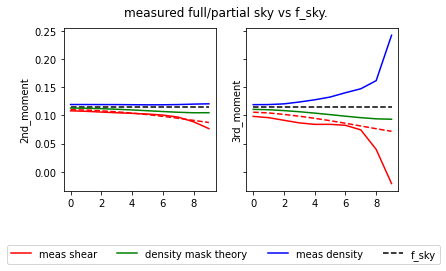

In [20]:
fig, ax = plt.subplots(1,2, figsize=(6,3),sharey = True)

plt.suptitle('measured full/partial sky vs f_sky.')
ax[0].plot(mcal_moments.moments['kEkE_masked']['0_0']/mcal_moments.moments['kEkE']['0_0'],color='r')
ax[0].plot(mcal_moments.moments['dd_masked']['0_0']/mcal_moments.moments['dd']['0_0'],color='blue')
ax[0].plot(f_sky*np.ones(len(conf['smoothing_scales'])),color='black',linestyle = 'dashed')
ax[0].plot(m2_masked/m2, label='density mask theory',color='g')


ax[0].plot(m2_k_masked/m2_k,color='r',linestyle='dashed')
ax[1].plot(m3_maskedE/m3,color='r',linestyle='dashed')



ax[1].plot(mcal_moments.moments['kEkE_masked']['0_0_0']/mcal_moments.moments['kEkE']['0_0_0'], label='meas shear',color='r')
ax[1].plot(m3_masked/m3, label='density mask theory',color='g')

ax[1].plot(mcal_moments.moments['dd_masked']['0_0_0']/mcal_moments.moments['dd']['0_0_0'], label='meas density',color='blue')
ax[1].plot(f_sky*np.ones(len(conf['smoothing_scales'])),color='black',linestyle = 'dashed', label = 'f_sky')
ax[0].set_ylabel('2nd_moment')
ax[1].set_ylabel('3rd_moment')
ax[1].legend(loc='upper center', bbox_to_anchor=(-0.15, -0.3), ncol=4)

# comparison with theory.


In [309]:
mapp_ave.moments.keys()

dict_keys(['field_full_kEkE', 'field_kEkE', 'density_full_kEkE', 'density_kEkE', 'density_KK_full', 'K_densitydensity_full', 'density_KK', 'K_densitydensity', 'noiseless_kEkE', 'noiseless_kBkB', 'kEkE', 'kBkB', 'kEkN', 'kNkN', 'kNBkNB', 'kNkE', 'dKK', 'Kdd', 'dkNkN', 'nKK', 'nkNkN', 'kNdd', 'knn', 'kNnn', 'dd', 'nn', 'dnn', 'ndd'])

/global/homes/m/mgatti/.conda/envs/py3s/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/global/homes/m/mgatti/.conda/envs/py3s/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


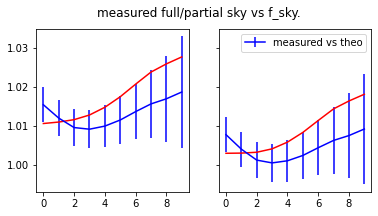

In [362]:
fig, ax = plt.subplots(1,2, figsize=(6,3),sharey = True)

ff  = (np.arange(2048)+2)*(np.arange(2048)-1)/(np.arange(2048)*(np.arange(2048)+1))



_,Cl_pix = hp.sphtfunc.pixwin(1024,pol=True)
_,Cl_pix_4096 = hp.sphtfunc.pixwin(4096,pol=True)


Cl_k= mapp_ave.PS['k_1_1'][:2048]*Cl_pix[:2048]**2/Cl_pix_4096[:2048]**2
ff[:2] =1.
Cl_k[:2] = 0
m2_k = compute_masked_2m(Cl_k, conf['smoothing_scales'], lmax = 2048)
Cl_k_masked = np.matmul(Cl_k[:2048]*ff,np.array(matrix_NaMaster['ME']).reshape(2048,2048).T)
m2_k_masked = compute_masked_2m(Cl_k_masked/ff, conf['smoothing_scales'], lmax = 2048)
m2 = compute_masked_2m(Cl_k, conf['smoothing_scales'], lmax = 2048)
plt.suptitle('measured full/partial sky vs f_sky.')
ax[0].errorbar(np.arange(len(m2)),(mapp_ave.moments['noiseless_kEkE']['0_0'])/(m2_k_masked),err2['noiseless_kEkE_0_0']/np.sqrt(100.)/m2_k_masked,color='b', label = 'measured vs theo')
ax[0].plot(((m2)/m2_k_masked)/((mapp_ave.moments['field_full_kEkE']['0_0'])/(mapp_ave.moments['field_kEkE']['0_0'])),color='r')


Cl_k_masked = np.matmul(Cl_k[:2048]*ff,np.array(matrix_NaMaster1['ME']).reshape(2048,2048).T)
m2_k_masked = compute_masked_2m(Cl_k_masked/ff, conf['smoothing_scales'], lmax = 2048)
m2 = compute_masked_2m(Cl_k, conf['smoothing_scales'], lmax = 2048)
plt.suptitle('measured full/partial sky vs f_sky.')
ax[1].errorbar(np.arange(len(m2)),(mapp_ave.moments['noiseless_kEkE']['0_0'])/(m2_k_masked),err2['noiseless_kEkE_0_0']/np.sqrt(100.)/m2_k_masked,color='b', label = 'measured vs theo')
ax[1].plot(((m2)/m2_k_masked)/((mapp_ave.moments['field_full_kEkE']['0_0'])/(mapp_ave.moments['field_kEkE']['0_0'])),color='r')

plt.legend()

# err2

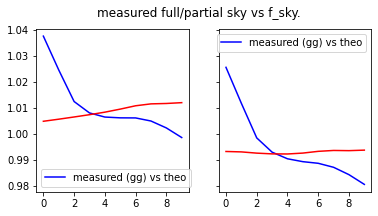

In [359]:
Cl_pix = hp.sphtfunc.pixwin(1024,pol=False)
Cl_pix_4096 = hp.sphtfunc.pixwin(4096,pol=False)

fig, ax = plt.subplots(1,2, figsize=(6,3),sharey = True)

Cl_k= mapp_ave.PS['lens_1_1'][:2048]*Cl_pix[:2048]**2/Cl_pix_4096[:2048]**2


#Cl_k = Cl_d_T17
Cl_k[:2] = 0
m2_k = compute_masked_2m(Cl_k, conf['smoothing_scales'], lmax = 2048)
Cl_k_masked = np.matmul(Cl_k[:2048],np.array(matrix_NaMaster['Mgg']).reshape(2048,2048).T)
m2_k_masked = compute_masked_2m(Cl_k_masked, conf['smoothing_scales'], lmax = 2048)
m2 = compute_masked_2m(Cl_k, conf['smoothing_scales'])

plt.suptitle('measured full/partial sky vs f_sky.')

# this doesn't have additional pixel mask. maybe just some shot noise that needs to be subtracted.
#ax[0].plot((mapp_ave.moments['density_kEkE']['0_0'])/(m2_k_masked),color='b', label = 'measured (density) vs theo')
ax[0].plot((mapp_ave.moments['dd']['0_0'])/(m2_k_masked),color='b', label = 'measured (gg) vs theo')
ax[0].plot(((m2)/m2_k_masked)/((mapp_ave.moments['density_full_kEkE']['0_0'])/(mapp_ave.moments['density_kEkE']['0_0'])),color='r')
ax[0].legend()



Cl_k_masked = np.matmul(Cl_k[:2048],np.array(matrix_NaMaster1['Mgg']).reshape(2048,2048).T)
m2_k_masked = compute_masked_2m(Cl_k_masked, conf['smoothing_scales'], lmax = 2048)
m2 = compute_masked_2m(Cl_k, conf['smoothing_scales'])

plt.suptitle('measured full/partial sky vs f_sky.')

# this doesn't have additional pixel mask. maybe just some shot noise that needs to be subtracted.
#ax[0].plot((mapp_ave.moments['density_kEkE']['0_0'])/(m2_k_masked),color='b', label = 'measured (density) vs theo')
ax[1].plot((mapp_ave.moments['dd']['0_0'])/(m2_k_masked),color='b', label = 'measured (gg) vs theo')
ax[1].plot(((m2)/m2_k_masked)/((mapp_ave.moments['density_full_kEkE']['0_0'])/(mapp_ave.moments['density_kEkE']['0_0'])),color='r')
ax[1].legend()

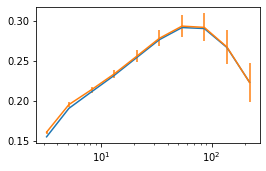

In [168]:
fig, ax = plt.subplots(1,1, figsize=(4,2.5))


plt.plot(conf['smoothing_scales'],m2_k_masked*conf['smoothing_scales'])
plt.errorbar(conf['smoothing_scales'],mapp_ave.moments['dd']['0_0']*conf['smoothing_scales'],err2['dd_0_0']*conf['smoothing_scales'])

ax.set_xscale('log')

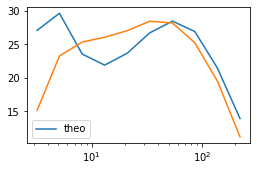

In [252]:
fig, ax = plt.subplots(1,1, figsize=(4,2.5))


plt.plot(conf['smoothing_scales'],m3*conf['smoothing_scales']**2,label = 'theo')
#plt.errorbar(conf['smoothing_scales'],mapp_ave.moments['density_full_kEkE']['0_0_0']*conf['smoothing_scales']**2,err2['dd_0_0_0']*conf['smoothing_scales']**2)
plt.plot(conf['smoothing_scales'],mcal_moments.moments['dd']['0_0_0']*conf['smoothing_scales']**2)
plt.legend()

ax.set_xscale('log')

/global/homes/m/mgatti/.conda/envs/py3s/lib/python3.6/site-packages/numpy/lib/function_base.py:2167: RuntimeWarning: overflow encountered in ? (vectorized)
  outputs = ufunc(*inputs)
/global/homes/m/mgatti/.conda/envs/py3s/lib/python3.6/site-packages/numpy/lib/function_base.py:2167: RuntimeWarning: divide by zero encountered in ? (vectorized)
  outputs = ufunc(*inputs)
/global/homes/m/mgatti/.conda/envs/py3s/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
/global/homes/m/mgatti/.conda/envs/py3s/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


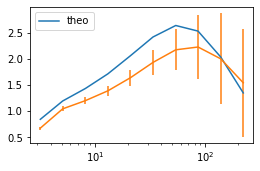

In [268]:
fig, ax = plt.subplots(1,1, figsize=(4,2.5))
m3_maskedE = 1./f_sky*compute_masked_3m(Cl_k, conf['smoothing_scales'],P_lz_masked = Cl_k_masked, lmax = 2048, sm_formulae = 'SC',xx=0.001)


#plt.plot(conf['smoothing_scales'],m3*conf['smoothing_scales']**2,label = 'theo')
plt.plot(conf['smoothing_scales'],m3_maskedE*conf['smoothing_scales']**2,label = 'theo')
plt.errorbar(conf['smoothing_scales'],mapp_ave.moments['density_kEkE']['0_0_0']*conf['smoothing_scales']**2,err2['dd_0_0_0']*conf['smoothing_scales']**2)
#plt.plot(conf['smoothing_scales'],mcal_moments.moments['dd']['0_0_0']*conf['smoothing_scales']**2)
plt.legend()

ax.set_xscale('log')

/global/homes/m/mgatti/.conda/envs/py3s/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/global/homes/m/mgatti/.conda/envs/py3s/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in multiply
  """Entry point for launching an IPython kernel.
/global/homes/m/mgatti/.conda/envs/py3s/lib/python3.6/site-packages/numpy/lib/function_base.py:2167: RuntimeWarning: overflow encountered in ? (vectorized)
  outputs = ufunc(*inputs)
/global/homes/m/mgatti/.conda/envs/py3s/lib/python3.6/site-packages/numpy/lib/function_base.py:2167: RuntimeWarning: divide by zero encountered in ? (vectorized)
  outputs = ufunc(*inputs)
/global/homes/m/mgatti/.conda/envs/py3s/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
/global/homes/m/mgatti/.conda/envs/py3s/lib/python3.6/site-packages/ipykernel_

# test masked theory

In [ ]:
# theory comparison!
m2 = compute_masked_2m(Cl_d, conf['smoothing_scales'], lmax = 2048)
m3 = compute_masked_3m(Cl_d, conf['smoothing_scales'], lmax = 2048, sm_formulae = 'GM')

Cl_d_masked = np.matmul(Cl_d[:2048],np.array(matrix['Mgg']).reshape(2048,2048).T)

m2_masked = compute_masked_2m(Cl_d_masked, conf['smoothing_scales'], lmax = 2048)
m3_masked = compute_masked_3m(Cl_d, conf['smoothing_scales'],P_lz_masked = Cl_d_masked/f_sky, lmax = 2048, sm_formulae = 'GM')

fig, ax = plt.subplots(1,2, figsize=(5,2))
ax[0].plot(mcal_moments.moments['dd']['0_0']/m2)
ax[1].plot(mcal_moments.moments['dd']['0_0_0']/m3)
#ax[1].plot(m3)

mcal_moments.moments['dd']['0_0_0']/m3

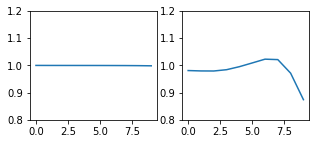

(0.8, 1.2)

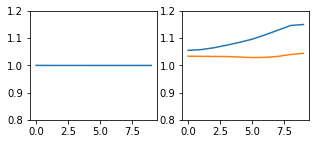

In [418]:
Cl_k_masked = np.matmul(Cl_k[:2048],np.array(matrix['ME']).reshape(2048,2048).T)
#Cl_k_masked = np.matmul(MEE[:2048,:][:,:2048],Cl_k[:2048])


m2 = compute_masked_2m(Cl_k, conf['smoothing_scales'], lmax = 2048)
m2_masked = compute_masked_2m(Cl_k_masked, conf['smoothing_scales'], lmax = 2048)

fig, ax = plt.subplots(1,2, figsize=(5,2))
ax[0].plot(mcal_moments.moments['kEkE']['0_0']/m2)
ax[1].plot(mcal_moments.moments['kEkE_masked']['0_0']/m2_masked)
ax[0].set_ylim([0.8,1.2])
ax[1].set_ylim([0.8,1.2])
plt.show()

Cl_d_masked_th = np.matmul(np.array(matrix['Mgg']).reshape(2048,2048),Cl_d[:2048])
#Cl_d_masked_th = np.matmul(Mgg[:2048,:][:,:2048],Cl_d[:2048])
m2 = compute_masked_2m(Cl_d, conf['smoothing_scales'], lmax = 2048)
m2_masked = compute_masked_2m(Cl_d_masked_th, conf['smoothing_scales'], lmax = 2048)

fig, ax = plt.subplots(1,2, figsize=(5,2))
ax[0].plot(mcal_moments.moments['dd']['0_0']/m2)
ax[1].plot(mcal_moments.moments['dd_masked']['0_0']/m2_masked)


ax[1].plot(mcal_moments.moments['dd_masked']['0_0']/f_sky/mcal_moments.moments['dd']['0_0'])

ax[0].set_ylim([0.8,1.2])
ax[1].set_ylim([0.8,1.2])
#


# test extra information in FLASK 4096 maps

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import pyfits as pf
mute = pf.open('/global/cscratch1/sd/mgatti/Mass_Mapping/taka/maps_0/k_1024_10.fits')
k = mute[1].data['field']
mute = pf.open('/global/cscratch1/sd/mgatti/Mass_Mapping/taka/maps_0/k_4096_10.fits')
k_4096 = mute[1].data['field']

# compute Cl
print (1024)
Cl_k = hp.anafast(k)
print (4096)
Cl_k_4096 = hp.anafast(k_4096)

print('done')
conf = dict()
conf['smoothing_scales'] = np.array([3.2,5.1,8.2,13.1,21.0,33.6,54.,86.,138,221.]) # arcmin
_,Cl_pix = hp.sphtfunc.pixwin(1024,pol=True)

m2 = compute_masked_2m(Cl_k, conf['smoothing_scales'], lmax = 2048)
m2_4096_2048 = compute_masked_2m(Cl_k_4096[:len(Cl_pix)]*Cl_pix**2, conf['smoothing_scales'], lmax = 2048)
m2_4096 = compute_masked_2m(Cl_k_4096[:len(Cl_pix)]*Cl_pix**2, conf['smoothing_scales'], lmax = 3072)


plt.plot(conf['smoothing_scales'],m2_4096/m2_4096_2048,label = 'lmax cut')
plt.plot(conf['smoothing_scales'],m2_4096_2048/m2, label ='ud_grade')
plt.legend()
plt.xscale('log', nonposx='clip')

'''
caveat: 
ud_grade : 4096 should be deconvolved by pix functionat nside = 4096.
lmax_cut: in principle, we cut that bit during the KS process, so it should'nt really be important

'''

1024
4096


In [111]:
1

1

In [ ]:
IndexToDeclRa(index, nside,nest= False):
theta,phi=hp.pixelfunc.pix2ang(nside ,index,nest=nest)
return -np.degrees(theta-np.pi/2.),np.degrees(phi)

In [109]:
'''
Need to compare four cases
1) uniform distribution across the footprint
2) not uniform distribution
3) impact of weights
4) de-noise

'''


import gc
import pyfits as pf
import pickle
import numpy as np
import healpy as hp
import os
from Moments_analysis import convert_to_pix_coord, IndexToDeclRa, apply_random_rotation, addSourceEllipticity
def save_obj(name, obj):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        f.close()

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        mute =  pickle.load(f)
        f.close()
    return mute



In [110]:


seed = 1

FLASK_path = '/global/cscratch1/sd/faoli/flask_desy3/4096/'
output = '/global/cscratch1/sd/mgatti/Mass_Mapping/moments/flask/'
mcal_catalog = load_obj('/project/projectdirs/des/mass_maps/Maps_final/data_catalogs_weighted')
    
i = 0 # first tomo bin
FLASK_shear = pf.open(FLASK_path+'seed'+str(seed+1)+'/kappa-gamma-f10z'+str(i+1)+'.fits')
k = FLASK_shear[1].data['signal'].reshape(196608*1024)
g1 = FLASK_shear[1].data['Q-pol'].reshape(196608*1024)
g2 = FLASK_shear[1].data['U-pol'].reshape(196608*1024)
del FLASK_shear

# pixels & random pixels **********
dec1 = mcal_catalog[i]['dec']
ra1 = mcal_catalog[i]['ra']
w = mcal_catalog[i]['w']
pix = convert_to_pix_coord(ra1,dec1, nside=4096)

In [112]:
g1_1024 = hp.alm2map(hp.map2alm(g1,lmax = 2048),nside = 1024)

array([100149233, 100149233, 100149233, ..., 103848030, 103831646,
       103831647])

In [16]:


nside = 1024
pix_1024 = convert_to_pix_coord(ra1,dec1, nside=nside)

index_pix_rndm = np.random.randint(0,len(np.unique(pix)),len(pix))  
pix_rndm = np.unique(pix)[index_pix_rndm]
dec1_rndm, ra1_rndm = IndexToDeclRa(pix_rndm, 4096,nest= False)
pix_rndm_1024 = convert_to_pix_coord(ra1_rndm,dec1_rndm, nside=nside)


g1_y3 = g1[pix]
g2_y3 = g2[pix]
g1_rndm = g1[pix_rndm]
g2_rndm = g2[pix_rndm]


es1,es2 = apply_random_rotation(mcal_catalog[i]['e1'], mcal_catalog[i]['e2'])
e1_y3,e2_y3 = addSourceEllipticity({'shear1':g1_y3,'shear2':g2_y3},{'e1':es1,'e2':es2},es_colnames=("e1","e2"))
e1_y3_rndm,e2_y3_rndm = addSourceEllipticity({'shear1':g1_rndm,'shear2':g2_rndm},{'e1':es1,'e2':es2},es_colnames=("e1","e2"))
         
# repeat the rotation such that we have a different noise realisation for the noise map.
es1,es2 = apply_random_rotation(mcal_catalog[i]['e1'], mcal_catalog[i]['e2'])
        
    

k_orig = np.zeros(hp.nside2npix(nside))
n_map = np.zeros(hp.nside2npix(nside))
n_map_unif = np.zeros(hp.nside2npix(nside))

g1_map = np.zeros(hp.nside2npix(nside))
g2_map = np.zeros(hp.nside2npix(nside))
g1_map_unif = np.zeros(hp.nside2npix(nside))
g2_map_unif = np.zeros(hp.nside2npix(nside))
e1_map = np.zeros(hp.nside2npix(nside))
e2_map = np.zeros(hp.nside2npix(nside))
e1_map_unif = np.zeros(hp.nside2npix(nside))
e2_map_unif = np.zeros(hp.nside2npix(nside))
       
e1_noise_map = np.zeros(hp.nside2npix(nside))
e2_noise_map = np.zeros(hp.nside2npix(nside))
e1_noise_map_unif = np.zeros(hp.nside2npix(nside))
e2_noise_map_unif = np.zeros(hp.nside2npix(nside))
  
unique_pix, idx, idx_rep = np.unique(pix_1024, return_index=True, return_inverse=True)
n_map[unique_pix] += np.bincount(idx_rep, weights=np.ones(len(pix_1024)))
g1_map[unique_pix] += np.bincount(idx_rep, weights= g1_y3)
g2_map[unique_pix] += np.bincount(idx_rep, weights= g2_y3)
e1_map[unique_pix] += np.bincount(idx_rep, weights= e1_y3)
e2_map[unique_pix] += np.bincount(idx_rep, weights= e2_y3)
e1_noise_map[unique_pix] += np.bincount(idx_rep, weights= es1)
e2_noise_map[unique_pix] += np.bincount(idx_rep, weights= es2)
mask_sims = n_map != 0.
g1_map[mask_sims] = g1_map[mask_sims]/n_map[mask_sims]
g2_map[mask_sims] = g2_map[mask_sims]/n_map[mask_sims]
e1_map[mask_sims] = e1_map[mask_sims]/n_map[mask_sims]
e2_map[mask_sims] = e2_map[mask_sims]/n_map[mask_sims]
e1_noise_map[mask_sims] = e1_noise_map[mask_sims]/n_map[mask_sims]
e2_noise_map[mask_sims] = e2_noise_map[mask_sims]/n_map[mask_sims]


unique_pix, idx, idx_rep = np.unique(pix_rndm_1024, return_index=True, return_inverse=True)
n_map_unif[unique_pix] += np.bincount(idx_rep, weights=np.ones(len(pix_rndm_1024)))
g1_map_unif[unique_pix] += np.bincount(idx_rep, weights= g1_y3)
g2_map_unif[unique_pix] += np.bincount(idx_rep, weights= g2_y3)
e1_map_unif[unique_pix] += np.bincount(idx_rep, weights= e1_y3)
e2_map_unif[unique_pix] += np.bincount(idx_rep, weights= e2_y3)
e1_noise_map_unif[unique_pix] += np.bincount(idx_rep, weights= es1)
e2_noise_map_unif[unique_pix] += np.bincount(idx_rep, weights= es2)

mask_sims = n_map_unif != 0.
g1_map_unif[mask_sims] = g1_map_unif[mask_sims]/n_map_unif[mask_sims]
g2_map_unif[mask_sims] = g2_map_unif[mask_sims]/n_map_unif[mask_sims]
e1_map_unif[mask_sims] = e1_map_unif[mask_sims]/n_map_unif[mask_sims]
e2_map_unif[mask_sims] = e2_map_unif[mask_sims]/n_map_unif[mask_sims]
e1_noise_map_unif[mask_sims] = e1_noise_map_unif[mask_sims]/n_map_unif[mask_sims]
e2_noise_map_unif[mask_sims] = e2_noise_map_unif[mask_sims]/n_map_unif[mask_sims]


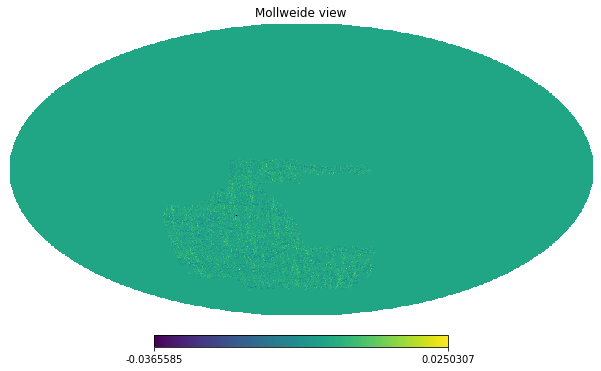

In [39]:
hp.mollview(g1_map_unif-g1_map)

In [32]:
# measure convergence field
def return_Cl(shear1,shear2):
    lmax = 2*nside
    KQU_masked_maps = [shear1,shear1,shear2]
    ell, emm = hp.Alm.getlm(lmax=lmax)
    alms = hp.map2alm(KQU_masked_maps, lmax=lmax, pol=True)  # Spin transform!
    alms_E = alms[1] * 1. * ((ell * (ell + 1.)) / ((ell + 2.) * (ell - 1))) ** 0.5
    return hp.alm2cl(alms_E,lmax=lmax )
    
Cl_uniform = return_Cl(g1_map_unif,g2_map_unif)
Cl = return_Cl(g1_map,g2_map)

Cl_e_uniform = return_Cl(e1_map_unif,e2_map_unif)
Cl_e = return_Cl(e1_map,e2_map)

Cl_n_uniform = return_Cl(e1_noise_map_unif,e2_noise_map_unif)
Cl_n = return_Cl(e1_noise_map,e2_noise_map)

/global/homes/m/mgatti/.conda/envs/py3s/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/global/homes/m/mgatti/.conda/envs/py3s/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


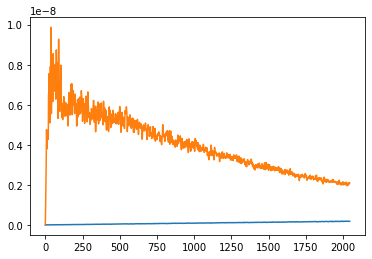

In [46]:
#plt.plot((Cl_e[3:]-Cl_n[3:])*np.arange(len(Cl_uniform[3:])))
plt.plot(Cl_uniform[3:]*np.arange(len(Cl_uniform[3:])))
plt.plot(Cl[3:]*np.arange(len(Cl_uniform[3:])))

In [50]:
output_FLASK = '/global/cscratch1/sd/mgatti/Mass_Mapping/moments/flask/'

n_FLASK_real = 50
tomo_bins = [0]
tomo_bins_lens = [0]


seed = 1
# I want to compute the full power spectrum of FLASK covariance for KS and density field as well. 
PS_dict = dict()
for i in tomo_bins:
    mute = pf.open(FLASK_path+'seed'+str(seed+1)+'/kappa-gamma-f10z{0}.fits'.format(i+1))
#for i in tomo_bins_lens:
    mute = pf.open(FLASK_path+'seed'+str(seed+1)+'/map-f{0}z{0}.fits'.format(i+1))
#

In [121]:
import copy


In [166]:
  
mask_DES_y3 = load_obj('/global/homes/m/mgatti/Mass_Mapping/Moments_analysis/Covariance/mask_DES_y3')
nside = 1024

seed = 1
FLASK_lens = pf.open(FLASK_path+'seed'+str(seed+1)+'/lens-catalog.fits.gz')
lens_ra = FLASK_lens[1].data['ra']
lens_dec = FLASK_lens[1].data['dec']
lens_bin = FLASK_lens[1].data['galtype']


#density_full_maps = dict()
#density_maps = dict()
lenses_maps = dict()
random_maps = dict()
sources_maps = dict()
sources_cat = dict()
# loop over tomographic bins (lenses)
for i in range(1):
    mask_z = lens_bin == i+1
    lenses_maps[i] = np.zeros(hp.nside2npix(nside))
    pix1 = convert_to_pix_coord(lens_ra[mask_z],lens_dec[mask_z], nside=nside)
    unique_pix1, idx1, idx_rep1 = np.unique(pix1, return_index=True, return_inverse=True)
    lenses_maps[i][unique_pix1] += np.bincount(idx_rep1, weights=np.ones(len(pix1)))
    mask = lenses_maps[i] != 0.
    number_of_lenses = np.int(np.sum(lenses_maps[i]))
    mean_N = np.mean(lenses_maps[i][mask_DES_y3])
    lenses_maps[i][mask_DES_y3] = (1.*lenses_maps[i][mask_DES_y3]-np.mean(lenses_maps[i][mask_DES_y3]))/np.mean(lenses_maps[i][mask_DES_y3])
    lenses_maps[i][~mask_DES_y3] =0.

    random_maps[i] = np.zeros(hp.nside2npix(nside))
    indexes = np.arange(len(lenses_maps[i]))[mask_DES_y3]
    pix_randoms = indexes[np.random.randint(0,len(indexes),number_of_lenses)]
    unique_pix1, idx1, idx_rep1 = np.unique(pix_randoms, return_index=True, return_inverse=True)
    random_maps[i][unique_pix1] += np.bincount(idx_rep1, weights=np.ones(len(pix_randoms)))
    mask = random_maps[i] != 0.
    random_maps[i][mask_DES_y3] = (random_maps[i][mask_DES_y3]-np.mean(random_maps[i][mask_DES_y3]))/np.mean(random_maps[i][mask_DES_y3])
    random_maps[i][~mask_DES_y3] =0.

    #mute = pf.open(FLASK_path+'seed'+str(seed+1)+'/map-f{0}z{0}.fits'.format(i+1))
    #density = mute[1].data['signal'].reshape(196608*1024)
    #density_full_maps[i]  = hp.alm2map(hp.map2alm(density,lmax = 2048),nside = 1024)
    #density_maps[i]  = copy.copy(density_full_maps[i])
    #density_maps[i][~mask_DES_y3] = 0

/global/homes/m/mgatti/.conda/envs/py3s/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


(array([4.3270e+03, 4.5610e+03, 4.7130e+03, 4.9660e+03, 5.1700e+03,
        5.2940e+03, 5.5220e+03, 5.6690e+03, 5.9060e+03, 6.1350e+03,
        6.2570e+03, 6.2700e+03, 6.6730e+03, 6.8930e+03, 7.0530e+03,
        7.0900e+03, 7.2160e+03, 7.4620e+03, 7.4060e+03, 7.3590e+03,
        7.4060e+03, 6.8190e+03, 6.6250e+03, 6.1250e+03, 5.3180e+03,
        4.4720e+03, 3.2780e+03, 2.2790e+03, 1.2450e+03, 4.9000e+02,
        9.2000e+01, 3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 2.0000e+00, 9.0000e+00, 3.8000e+01,
        8.1000e+01, 1.2600e+02, 2.1400e+02, 3.7400e+02, 6.8400e+02,
        1.4730e+03, 3.1100e+03, 5.6990e+03, 9.5500e+03, 1.3622e+04,
        1.7057e+04, 2.0446e+04, 2.2187e+04, 2.3440e+04, 2.4362e+04,
        2.3883e+04, 2.3863e+04, 2.3351e+04, 2.2320e+04, 2.1758e+04,
        2.0442e+04, 1.9527e+04, 1.8344e+04, 1.7689e+04, 1.6872e+04,
        1.6047e+04, 1.5454e+04, 1.4554e+04, 1.3834e+04, 1.3327e+04,
        1.2522e+04, 1.1948e+04, 1.1283e+04, 1.09

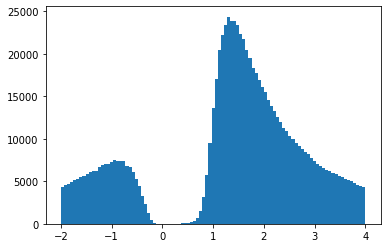

In [193]:
plt.hist((1.*lenses_maps[i]/density_maps[i])[mask_DES_y3], bins =  np.linspace(-2,4,100))



In [180]:
#Cl_d_full = hp.anafast(density_full_maps[i])
#Cl_d = hp.anafast(density_maps[i])
Cl_g = hp.anafast(lenses_maps[i])
Cl_n = hp.anafast(random_maps[i])

In [181]:
m2_d_full = compute_masked_2m(Cl_d_full, conf['smoothing_scales'], lmax = 2048)
m2_d_masked_t = compute_masked_2m(np.matmul(Cl_d_full[:2048],np.array(matrix['Mgg']).reshape(2048,2048).T), conf['smoothing_scales'], lmax = 2048)
m2_d_masked = compute_masked_2m(Cl_d, conf['smoothing_scales'], lmax = 2048)
m2_g_masked = compute_masked_2m(Cl_g, conf['smoothing_scales'], lmax = 2048)
m2_n_masked = compute_masked_2m(Cl_n, conf['smoothing_scales'], lmax = 2048)


In [164]:
m2_g_masked

array([1.07701594e-03, 6.18041225e-04, 2.71951169e-04, 1.26089844e-04,
       5.91711057e-05, 2.88650138e-05, 1.45489217e-05, 7.47361904e-06,
       3.68884709e-06, 1.70577158e-06])

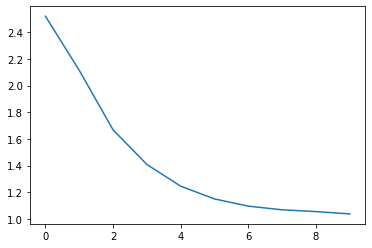

In [187]:
plt.plot((m2_g_masked-m2_n_masked)/m2_d_masked)

In [213]:
mean_N*f_sky,m2_d_masked

(0.03030610084533691,
 array([0.05231163, 0.03933386, 0.02646798, 0.01799315, 0.01225475,
        0.00833015, 0.00548452, 0.00343975, 0.00197463, 0.00103129]))

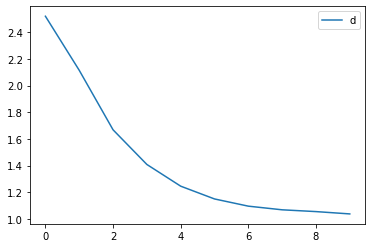

In [214]:
#plt.plot(m2_n_masked, label = 'n')
#plt.plot(m2_g_masked, label = 'g')
plt.plot((m2_g_masked-m2_n_masked)/m2_d_masked, label = 'd')
plt.legend()

In [177]:
mask_z = lens_bin == i+1
lenses_maps[i] = np.zeros(hp.nside2npix(nside))
pix1 = convert_to_pix_coord(lens_ra[mask_z],lens_dec[mask_z], nside=nside)
unique_pix1, idx1, idx_rep1 = np.unique(pix1, return_index=True, return_inverse=True)
lenses_maps[i][unique_pix1] += np.bincount(idx_rep1, weights=np.ones(len(pix1)))
mask = lenses_maps[i] != 0.
number_of_lenses = np.int(np.sum(lenses_maps[i]))
lenses_maps[i][mask_DES_y3] = (1.*lenses_maps[i][mask_DES_y3]-np.mean(lenses_maps[i][mask_DES_y3]))/np.mean(lenses_maps[i][mask_DES_y3])
lenses_maps[i][~mask_DES_y3] =0.

random_maps[i] = np.zeros(hp.nside2npix(nside))
indexes = np.arange(len(lenses_maps[i]))[mask_DES_y3]
pix_randoms = indexes[np.random.randint(0,len(indexes),number_of_lenses)]
unique_pix1, idx1, idx_rep1 = np.unique(pix_randoms, return_index=True, return_inverse=True)
random_maps[i][unique_pix1] += np.bincount(idx_rep1, weights=np.ones(len(pix_randoms)))
mask = random_maps[i] != 0.
random_maps[i][mask_DES_y3] = (random_maps[i][mask_DES_y3]-np.mean(random_maps[i][mask_DES_y3]))/np.mean(random_maps[i][mask_DES_y3])
random_maps[i][~mask_DES_y3] =0.

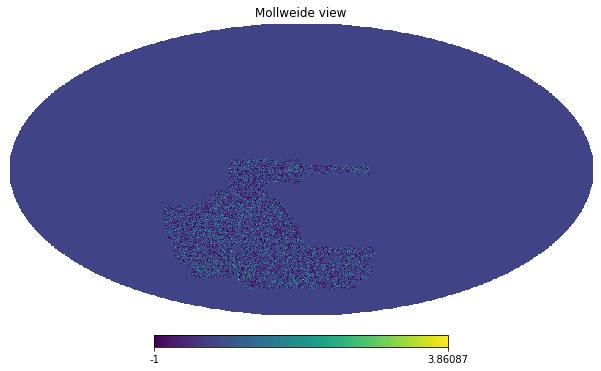

In [185]:
hp.mollview(random_maps[i])

(array([     0.,      0.,      0., 341728., 678676., 165354., 102953.,
          9148.,   3233.]),
 array([-3.        , -2.33333333, -1.66666667, -1.        , -0.33333333,
         0.33333333,  1.        ,  1.66666667,  2.33333333,  3.        ]),
 <a list of 1 Patch objects>)

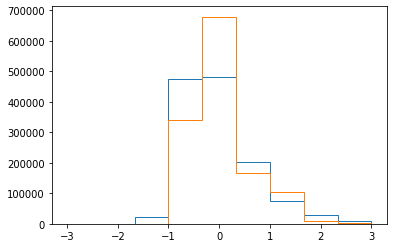

In [186]:
plt.hist(density_maps[i][mask], bins = np.linspace(-3,3,10), histtype = 'step')
plt.hist(random_maps[i][mask], bins = np.linspace(-3,3,10), histtype = 'step')

In [138]:
FLASK_path+'seed'+str(seed+1)

'/global/cscratch1/sd/faoli/flask_desy3/4096/seed2'

In [198]:
    mask_z = lens_bin == i+1
    lenses_maps[i] = np.zeros(hp.nside2npix(nside))
    pix1 = convert_to_pix_coord(lens_ra[mask_z],lens_dec[mask_z], nside=nside)
    unique_pix1, idx1, idx_rep1 = np.unique(pix1, return_index=True, return_inverse=True)
    lenses_maps[i][unique_pix1] += np.bincount(idx_rep1, weights=np.ones(len(pix1)))
    mask = lenses_maps[i] != 0.
    number_of_lenses = np.int(np.sum(lenses_maps[i]))
    mean_N = np.mean(lenses_maps[i][mask_DES_y3])
    N_tot = np.sum(lenses_maps[i][mask_DES_y3])
    lenses_maps[i][mask_DES_y3] = (1.*lenses_maps[i][mask_DES_y3]-np.mean(lenses_maps[i][mask_DES_y3]))/np.mean(lenses_maps[i][mask_DES_y3])
    lenses_maps[i][~mask_DES_y3] =0.

0.030306100845336914